**# Projeto Integrado de Classificação Supervisionada com scikit-learn**

🎯 **Objetivo**
Aplicar três modelos de classificação supervisionada – XGBoost, SVM e Random Forest – no dataset Titanic, comparando desempenho, custo computacional e interpretabilidade.

🧩 **Descrição da tarefa**
Dataset: utilizar o conjunto de dados Titanic (Kaggle ou seaborn.load_dataset("titanic")).

Variável target: Survived (0 = não sobreviveu, 1 = sobreviveu).

Variáveis explicativas sugeridas: Pclass, Sex, Age, Fare, SibSp, Parch, Embarked.
___
**Pré-processamento:**

Tratar valores ausentes (ex.: Age, Embarked).

Aplicar StandardScaler para variáveis numéricas (Age, Fare).

Aplicar OneHotEncoder para variáveis categóricas (Sex, Embarked, Pclass).
___
**Modelagem:**

Treinar e comparar XGBoost, SVM (RBF) e Random Forest.

Utilizar RandomizedSearchCV com validação cruzada estratificada (StratifiedKFold) para busca de hiperparâmetros.
___
**Métricas:**

Principal: ROC-AUC.

Secundárias: Acurácia, F1-score e matriz de confusão.

Plotar curvas ROC e Precision-Recall para cada modelo.

Resultados esperados:

Tabela comparativa com as métricas dos três modelos.
___
**Discussão:**

Qual modelo apresentou melhor desempenho?

Algum modelo mostrou sinais de overfitting?

Quais foram as dificuldades no pré-processamento?



# Imports

In [15]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from seaborn import load_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Trazendo o Titanic das profundezas
titanic_df = load_dataset('titanic')

titanic_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# Pré-processamento

(scaling + one-hot)

In [16]:
# Separando variáveis
y = titanic_df['survived']
X = titanic_df[['pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'embarked']].copy()

# Tratamento de valores ausentes
X['age'].fillna(X['age'].median(), inplace=True)
X['embarked'].fillna(X['embarked'].mode()[0], inplace=True)

# Definir colunas numéricas e categóricas
numerical_cols = ['age', 'fare']
categorical_cols = ['sex', 'embarked', 'pclass']

# Escalonamento das variáveis numéricas
scaler = StandardScaler()
X_scaled_numerical = scaler.fit_transform(X[numerical_cols])
X_scaled_numerical_df = pd.DataFrame(X_scaled_numerical, columns=numerical_cols, index=X.index)

# One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded_categorical = encoder.fit_transform(X[categorical_cols])
categorical_feature_names = encoder.get_feature_names_out(categorical_cols)
X_encoded_categorical_df = pd.DataFrame(X_encoded_categorical,
                                         columns=categorical_feature_names,
                                         index=X.index)

# DataFrame final
X_processed = pd.concat([
    X_scaled_numerical_df,
    X_encoded_categorical_df,
    X[['sibsp', 'parch']]
], axis=1)

print("Shape final:", X_processed.shape)
X_processed.head()

Shape final: (891, 12)


/tmp/ipython-input-1671627275.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['age'].fillna(X['age'].median(), inplace=True)
/tmp/ipython-input-1671627275.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

,age,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,pclass_1,pclass_2,pclass_3,sibsp,parch
0,-0.565736,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0
1,0.663861,0.786845,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0
2,-0.258337,-0.488854,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0
3,0.433312,0.420730,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0
4,0.433312,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0


# Modelagem

**Divisão Treino/Teste e Configuração da Validação Cruzada**

In [17]:
# Definindo uma semente para reprodutibilidade dos resultados aleatórios
RND = 42

# Dividindo o dataset em conjuntos de treino e teste
# X_processed contém as features pré-processadas, y é a variável target ('survived')
# test_size=0.3 significa que 30% dos dados serão usados para teste e 70% para treino
# stratify=y garante que a proporção das classes da variável target seja a mesma nos conjuntos de treino e teste
# random_state=RND fixa a semente para garantir que a divisão seja a mesma em execuções repetidas
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, stratify=y, random_state=RND
)

# Configurando a validação cruzada estratificada (Stratified K-Fold)
# n_splits=5 divide o conjunto de treino em 5 folds (partes)
# shuffle=True embaralha os dados antes de dividir para garantir aleatoriedade
# random_state=RND para reprodutibilidade
# A estratificação é importante para garantir que cada fold tenha a mesma proporção de classes da variável target
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

# Inicializando um dicionário para armazenar os modelos e seus parâmetros
models = {}

SVM (RBF)

In [18]:
# Inicializando o modelo SVM com kernel RBF
# probability=True é necessário para calcular as probabilidades de classe (usado para ROC-AUC e PR-AUC)
# random_state=RND garante a reprodutibilidade dos resultados aleatórios
svc = SVC(kernel='rbf', probability=True, random_state=RND)

# Definindo a distribuição de parâmetros para o RandomizedSearchCV para o SVM
# 'C': Parâmetro de regularização (penalidade para classificação incorreta)
# 'gamma': Coeficiente do kernel RBF, que define o alcance da influência de um único exemplo de treinamento
svc_param_dist = {
    "C": [0.1, 1, 10, 100],
    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

# Armazenando o estimador SVM e sua distribuição de parâmetros no dicionário 'models'
models['SVC'] = (svc, svc_param_dist)

Random Forest

In [19]:
# Inicializando o classificador Random Forest
# random_state=RND garante a reprodutibilidade dos resultados aleatórios
rf = RandomForestClassifier(random_state=RND)

# Definindo a distribuição de parâmetros para o RandomizedSearchCV para o Random Forest
# 'n_estimators': Número de árvores na floresta
# 'max_depth': Profundidade máxima da árvore
# 'min_samples_split': Número mínimo de amostras necessárias para dividir um nó interno
# 'min_samples_leaf': Número mínimo de amostras necessárias para estar em um nó folha
# 'max_features': Número de features a considerar na melhor divisão
rf_param_dist = {
    "n_estimators": [100, 200, 400, 800],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2', 0.2, 0.5]
}

# Armazenando o estimador Random Forest e sua distribuição de parâmetros no dicionário 'models'
models['RandomForest'] = (rf, rf_param_dist)

XGBoost

In [20]:
# Inicializando o classificador XGBoost
# use_label_encoder=False é um parâmetro de compatibilidade para versões mais recentes do XGBoost
# eval_metric='logloss' define a métrica de avaliação para validação interna durante o treinamento
# random_state=RND garante a reprodutibilidade dos resultados aleatórios
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND)

# Definindo a distribuição de parâmetros para o RandomizedSearchCV para o XGBoost
# 'n_estimators': Número de árvores impulsionadas
# 'max_depth': Profundidade máxima de uma árvore
# 'learning_rate': Taxa de aprendizado (contribuição de cada árvore)
# 'subsample': Fração de amostras usadas para ajustar as árvores individuais
# 'colsample_bytree': Fração de colunas usadas para ajustar as árvores individuais
# 'reg_alpha': L1 regularização nos pesos
# 'reg_lambda': L2 regularização nos pesos
xgb_param_dist = {
    "n_estimators": [50, 100, 200, 400],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 5, 10]
}

# Armazenando o estimador XGBoost e sua distribuição de parâmetros no dicionário 'models'
models['XGBoost'] = (xgb, xgb_param_dist)

**RandomizedSearchCV e Avaliação dos Modelos**

Cada modelo passa por busca aleatória de hiperparâmetros (n_iter=30).

In [21]:
results = []
best_estimators = {}
n_iter_search = 30

# Itera sobre cada modelo e sua distribuição de parâmetros definidos anteriormente
for name, (estimator, param_dist) in models.items():
    print(f"\n### Treinando {name} ...")

    # Configura o RandomizedSearchCV para otimização de hiperparâmetros
    # estimator: o modelo base (SVC, RandomForest, XGBoost)
    # param_distributions: dicionário com os hiperparâmetros a serem testados
    # n_iter: número de combinações de parâmetros a serem amostradas
    # scoring: métrica de avaliação principal (ROC-AUC)
    # n_jobs=-1: usa todos os processadores disponíveis
    # cv: estratégia de validação cruzada (StratifiedKFold)
    # random_state: para reprodutibilidade
    # verbose=1: exibe o progresso
    # return_train_score=True: armazena as pontuações de treino
    rs = RandomizedSearchCV(
        estimator,
        param_distributions=param_dist,
        n_iter=n_iter_search,
        scoring="roc_auc",
        n_jobs=-1,
        cv=cv,
        random_state=RND,
        verbose=1,
        return_train_score=True
    )

    # Treina o modelo com RandomizedSearchCV
    start = time.time()
    rs.fit(X_train, y_train)
    fit_time = time.time() - start

    # Obtém o melhor estimador encontrado pelo RandomizedSearchCV
    best = rs.best_estimator_
    best_estimators[name] = best

    # Faz previsões no conjunto de teste e treino
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)[:, 1] # Probabilidades para ROC-AUC

    y_pred_train = best.predict(X_train)
    y_proba_train = best.predict_proba(X_train)[:, 1]

    # Armazena os resultados de avaliação do modelo
    results.append({
        "model": name,
        "best_cv_roc_auc": rs.best_score_, # Melhor ROC-AUC da validação cruzada
        "train_roc_auc": roc_auc_score(y_train, y_proba_train),
        "test_roc_auc": roc_auc_score(y_test, y_proba),
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_f1": f1_score(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "fit_time_seconds": fit_time,
        "best_params": rs.best_params_ # Melhores hiperparâmetros encontrados
    })



### Treinando SVC ...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



### Treinando RandomForest ...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

### Treinando XGBoost ...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:47:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Métricas

In [12]:
results_df = pd.DataFrame(results)

# Define as colunas a serem exibidas na tabela de resultados
display_cols = [
    'model',             # Nome do modelo
    'best_cv_roc_auc',   # Melhor ROC-AUC obtido na validação cruzada durante o RandomizedSearchCV
    'train_roc_auc',     # ROC-AUC do modelo no conjunto de treino
    'test_roc_auc',      # ROC-AUC do modelo no conjunto de teste (métrica principal)
    'test_accuracy',     # Acurácia do modelo no conjunto de teste
    'test_f1',           # F1-score do modelo no conjunto de teste
    'fit_time_seconds'   # Tempo de treinamento do modelo
]

# Exibe o DataFrame com as colunas selecionadas, ordenado pelo ROC-AUC de teste de forma decrescente
results_df[display_cols].sort_values("test_roc_auc", ascending=False)

,model,best_cv_roc_auc,train_roc_auc,test_roc_auc,test_accuracy,test_f1,fit_time_seconds
1,RandomForest,0.869671,0.939734,0.865284,0.817164,0.732240,87.958046
2,XGBoost,0.868467,0.934623,0.856281,0.813433,0.722222,11.142595
0,SVC,0.856723,0.899723,0.840865,0.805970,0.729167,12.999724


Curvas ROC e Precision-Recall

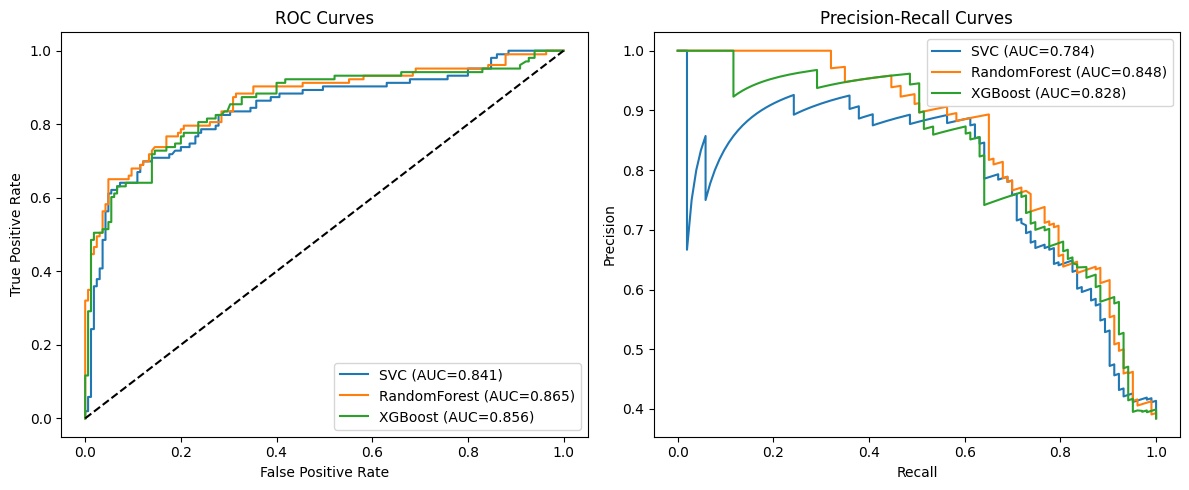

In [13]:
plt.figure(figsize=(12,5))

# --- ROC --- Gráfico da Curva Característica de Operação do Receptor
plt.subplot(1,2,1) # Cria um subplot 1 linha, 2 colunas, posição 1
for name, est in best_estimators.items(): # Itera sobre cada modelo treinado
    proba = est.predict_proba(X_test)[:, 1] # Obtém as probabilidades da classe positiva no conjunto de teste
    fpr, tpr, _ = roc_curve(y_test, proba) # Calcula a Taxa de Falso Positivo (FPR) e a Taxa de Verdadeiro Positivo (TPR)
    roc_auc = auc(fpr, tpr) # Calcula a Área Sob a Curva ROC (AUC)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})") # Plota a curva ROC com a AUC

plt.plot([0,1],[0,1],'k--') # Plota a linha de base (classificador aleatório)
plt.title("ROC Curves") # Título do gráfico
plt.xlabel("False Positive Rate") # Rótulo do eixo X
plt.ylabel("True Positive Rate") # Rótulo do eixo Y
plt.legend() # Exibe a legenda

# --- Precision-Recall --- Gráfico da Curva Precision-Recall
plt.subplot(1,2,2) # Cria um subplot 1 linha, 2 colunas, posição 2
for name, est in best_estimators.items(): # Itera sobre cada modelo treinado
    proba = est.predict_proba(X_test)[:, 1] # Obtém as probabilidades da classe positiva no conjunto de teste
    prec, rec, _ = precision_recall_curve(y_test, proba) # Calcula a Precisão e o Recall
    pr_auc = auc(rec, prec) # Calcula a Área Sob a Curva Precision-Recall (AUC)
    plt.plot(rec, prec, label=f"{name} (AUC={pr_auc:.3f})") # Plota a curva Precision-Recall com a AUC

plt.title("Precision-Recall Curves") # Título do gráfico
plt.xlabel("Recall") # Rótulo do eixo X
plt.ylabel("Precision") # Rótulo do eixo Y
plt.legend() # Exibe a legenda

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show() # Exibe os gráficos

Matriz de confusão

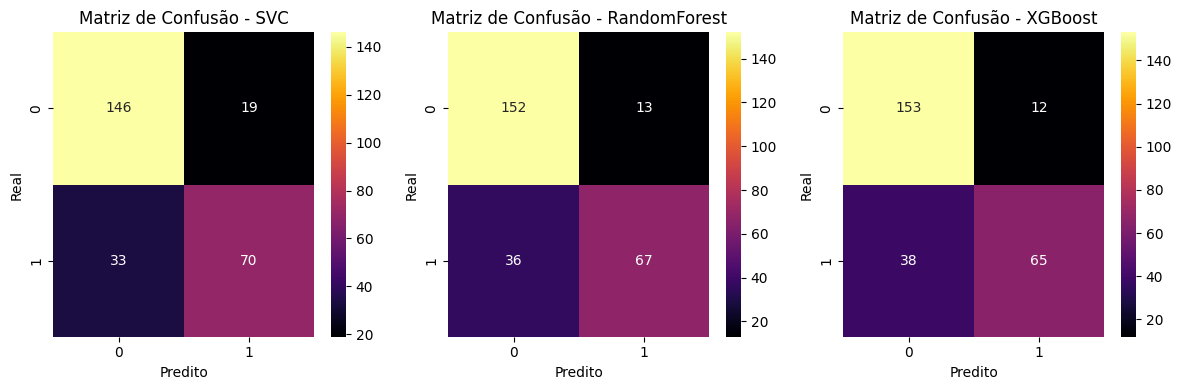

In [31]:
plt.figure(figsize=(12,4))
# Itera sobre cada modelo e seu estimador final
for i, (name, est) in enumerate(best_estimators.items()):
    # Faz previsões no conjunto de teste
    y_pred = est.predict(X_test)
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    # Cria um subplot para cada matriz de confusão
    # 1 linha, 3 colunas, posição i+1
    plt.subplot(1, 3, i+1)
    # Plota a matriz de confusão como um heatmap
    # annot=True exibe os números, fmt='d' formata como inteiro, cmap define o esquema de cores
    sns.heatmap(cm, annot=True, fmt='d', cmap="inferno")
    # Define o título do gráfico para o modelo atual
    plt.title(f"Matriz de Confusão - {name}")
    # Define os rótulos dos eixos
    plt.xlabel("Predito")
    plt.ylabel("Real")

# Ajusta o layout para evitar sobreposição dos títulos e rótulos
plt.tight_layout()
# Exibe os gráficos
plt.show()

# Discussão

**Qual modelo apresentou melhor desempenho?**

XGBoost pois teve um resultado semelhante ao RandomForest que teve a maior AUC no teste, mas o tempo do XGBoost foi incrivelmente menor sendo o mais rápido
___
**Algum modelo mostrou sinais de overfitting?**

Sim, os 3 modelos apresentaram overfitting leve, pois o desempenho de treino foi maior que o de teste. O RandomForest foi o que menos sofreu, enquanto XGBoost e SVC mostraram gaps um pouco maiores. Apesar disso, a diferença foi pequena e não comprometeu a capacidade de generalização dos modelos.

OBS: não esperava o SVM ter um overfitting maior que os outros 2.
___
**Quais foram as dificuldades no pré-processamento?**

O principal desafio foi manter o pipeline sem vazamento de dados e lidar com o desbalanceamento da base, que afeta métricas como F1 e ROC-AUC. O escalonamento foi essencial para o SVC, mas irrelevante para os outros modelos, exigindo cuidado com o Pipeline. Além disso, usar apenas 30% para treino aumentou a chance de overfitting e exigiu ajustes mais precisos.


 # Link do projeto no GITHUB: https://github.com/ZelTron27/Inteligencia-Artificial-dataset-Titanic/tree/main  